#🦕🦾 **GROUNDINGDINO DEMO 🦾🦕**

This notebook is a google colab demo to run a single image on GroundingDINO.
To run on your own images, a few changes have to be made:
- The image path to the image you want to run the model on
- The prompt to give GroundingDINO. It is recommended use "." to seperate different objects you want to detect.

It is recommended to use a GPU to speed up inference times. If you run this in google colab, this can be done by going to Runtime -> Change Runtime -> T4 GPU.

(Note: currently the groundingDINO model could not be finetuned, so there are no finetuned parameter weights. You can use the base GroundingDINO model instead)

## Loading GroundingDINO and other modules

Load and install all modules necessary

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install supervision fastapi kaleido python-multipart uvicorn
!pip install -q roboflow dataclasses-json onemetric

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import re

import os, cv2, bisect
import supervision as sv
import torch
import torch.nn as nn

random_seed = 42
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

HOME = os.getcwd()
print(HOME)

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.22.0 requires typ

In [ ]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!pip install -q -e .
!pip install -q roboflow

CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

%cd {HOME}/GroundingDINO
from groundingdino.util.inference import load_model, load_image, predict, annotate, Model
from groundingdino.util.box_ops import box_iou, box_cxcywh_to_xyxy
from groundingdino.util.utils import get_phrases_from_posmap
# model = load_model(CONFIG_PATH, WEIGHTS_PATH)

from onemetric.cv.object_detection import MeanAveragePrecision,AveragePrecision,ConfusionMatrix

/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 421, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 421 (delta 145), reused 128 (delta 128), pack-reused 231
Receiving objects: 100% (421/421), 12.85 MiB | 23.76 MiB/s, done.
Resolving deltas: 100% (216/216), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.3 MB/s eta 0:00:00
/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True
/content
/content/weights
/content/weights/groundingdino_swint_ogc.pth ; exist: True
/content/GroundingDINO


In [ ]:
def preprocess_caption(caption: str) -> str:
    result = caption.lower().strip()
    if result.endswith("."):
        return result
    return result + "."

In [ ]:
class GroundingDINOV2(nn.Module):
    def __init__(self, box_threshold=0.35, text_threshold=0.25, WEIGHTS_PATH = WEIGHTS_PATH):
        super(GroundingDINOV2, self).__init__()

        self.box_threshold = box_threshold
        self.text_threshold = text_threshold

        self.basemodel = load_model(CONFIG_PATH, WEIGHTS_PATH)

    def basemodel_forward(self, image, caption, remove_combined=False):
        """
        This function is mainly from the GD Github and slightly modified to also output
        the prediction_logits without the mask .max(dim=1)[0] being applied.
        """
        caption = preprocess_caption(caption)
        outputs = self.basemodel(image[None], captions=[caption])

        prediction_logits = outputs["pred_logits"].sigmoid()[0]  # prediction_logits.shape = (nq, 256)
        prediction_logits_no_sigmoid = outputs["pred_logits"][0]  # prediction_logits.shape = (nq, 256)
        prediction_boxes = outputs["pred_boxes"][0]  # prediction_boxes.shape = (nq, 4)

        mask = prediction_logits.max(dim=1)[0] > self.box_threshold
        logits = prediction_logits[mask]  # logits.shape = (n, 256)
        boxes = prediction_boxes[mask]  # boxes.shape = (n, 4)

        logits_raw = prediction_logits[mask]

        tokenizer = self.basemodel.tokenizer
        tokenized = tokenizer(caption)

        if remove_combined:
            sep_idx = [i for i in range(len(tokenized['input_ids'])) if tokenized['input_ids'][i] in [101, 102, 1012]]

            phrases = []
            for logit in logits:
                max_idx = logit.argmax()
                insert_idx = bisect.bisect_left(sep_idx, max_idx)
                right_idx = sep_idx[insert_idx]
                left_idx = sep_idx[insert_idx - 1]
                phrases.append(get_phrases_from_posmap(logit > self.text_threshold, tokenized, tokenizer, left_idx, right_idx).replace('.', ''))
        else:
            phrases = [
                get_phrases_from_posmap(logit > self.text_threshold, tokenized, tokenizer).replace('.', '')
                for logit
                in logits
            ]

        return boxes, logits.max(dim=1)[0], phrases, logits_raw

    def forward(self, image, caption):
        """
        The forward function of the module. Also used met model(image, caption) is called.
        The forward functoin sends the inputs to self.basemodel_forward and returns self.basemodel_forward's outpus

        Args:
            - image: image in torch.tensor format
            - caption: string in format 'cls. cls2. cls3.'

        Returns:
            - boxes: found bounding boxes in cxcywh format
            - logits: probability of each final prediction
            - phrases: the found classes
            - logits_raw: the entire logits torch.tensor for each prediction
        """
        return self.basemodel_forward(image, caption)

In [ ]:
def compare_models(model1, model2, image_source, image_transformed, prompt, model_names=None):
    """
    Plot 4 images in a 2x2 grid with the original image, the groundtruth annotations, the annotations from model1 and the annotations from model2

    Args:
        - model1: a model of GroundingDINOV2 type
        - model2: a model of GroundingDINOV2 type
        - image_source: the image as np array
        - image_transformed: the image preprocessed using groundingDINO.load_image() as a tensor
        - prompt: the prompt inputted into the model
        - model_names: a list of the names of the two models we want to compare

    """

    model1.eval()
    model2.eval()

    with torch.no_grad():
        # Apply model1
        boxes, logits, phrases, _ = model1(image_transformed.to(device), prompt)
        boxes, logits = boxes.cpu(), logits.cpu()
        predicted_image1 = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

        # Apply model2
        boxes, logits, phrases, _ = model2(image_transformed.to(device), prompt)
        boxes, logits = boxes.cpu(), logits.cpu()
        predicted_image2 = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

    # set names for model in plot
    if model_names is None:
        model1_name, model2_name = ['model1','model2']
    else:
        model1_name, model2_name = model_names

    # Plot images in a (1,2) grid
    img_list = [predicted_image1,predicted_image2]
    sv.plot_images_grid(images=img_list,grid_size=(1,2),titles=[f'{model1_name} predictions', f'{model2_name} predictions'],size=(16,12))

## Run GroundingDINO

In [ ]:
## Import unfinetuned model
unfinetuned_model = GroundingDINOV2()
unfinetuned_model = unfinetuned_model.to(device)


## Import finetuned model
finetuned_weights_path = None # set path to finetuned model

# if no path given, use basemodel
if finetuned_weights_path is None:
    finetuned_weights_path = WEIGHTS_PATH

finetuned_model = GroundingDINOV2(WEIGHTS_PATH = finetuned_weights_path)
finetuned_model = finetuned_model.to(device)

final text_encoder_type: bert-base-uncased
final text_encoder_type: bert-base-uncased


In [ ]:
# Select which model to use for evaluation. True if you want to use the finetuned model, False if you want to use the unfinetuned model.
use_finetuned_model = False

if use_finetuned_model:
    model = finetuned_model
    model_name = 'finetuned'
else:
    model = unfinetuned_model
    model_name = 'unfinetuned'
print(f"Current model: {model_name} GroundingDINO")

Current model: unfinetuned GroundingDINO


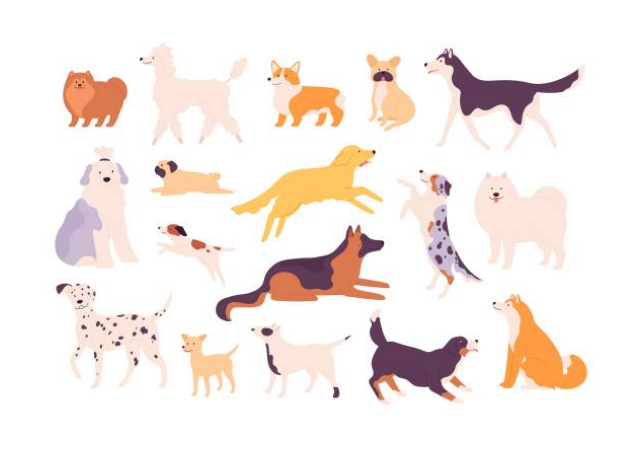

In [ ]:
# load image
IMAGE_PATH  = '/content/doggies.jpg'# enter filepath here

image_source, image_transformed = load_image(IMAGE_PATH)

# plot image
image_rgb = cv2.cvtColor(image_source, cv2.COLOR_RGB2BGR)
sv.plot_image(image_rgb,size=(8,8))

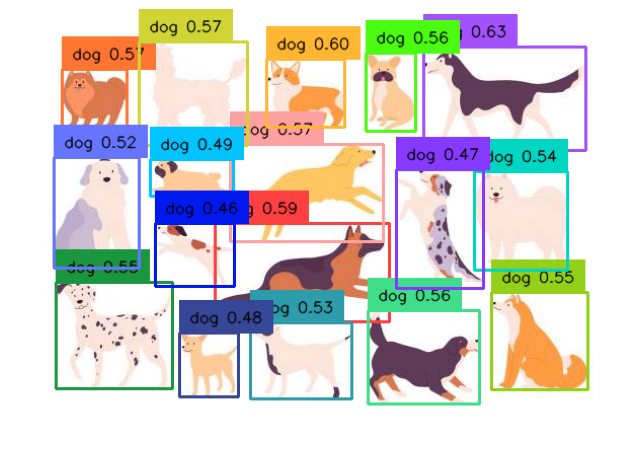

In [ ]:
# Define the prompt used for groundingDINO
prompt = 'dog'

# Run finetuned model on image and plot annotations
model.eval()
with torch.no_grad():
    boxes, logits, phrases, _ = model(image_transformed.to(device), prompt)
    boxes, logits = boxes.cpu(), logits.cpu()
annotated_image = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
sv.plot_image(annotated_image,size=(8,8))

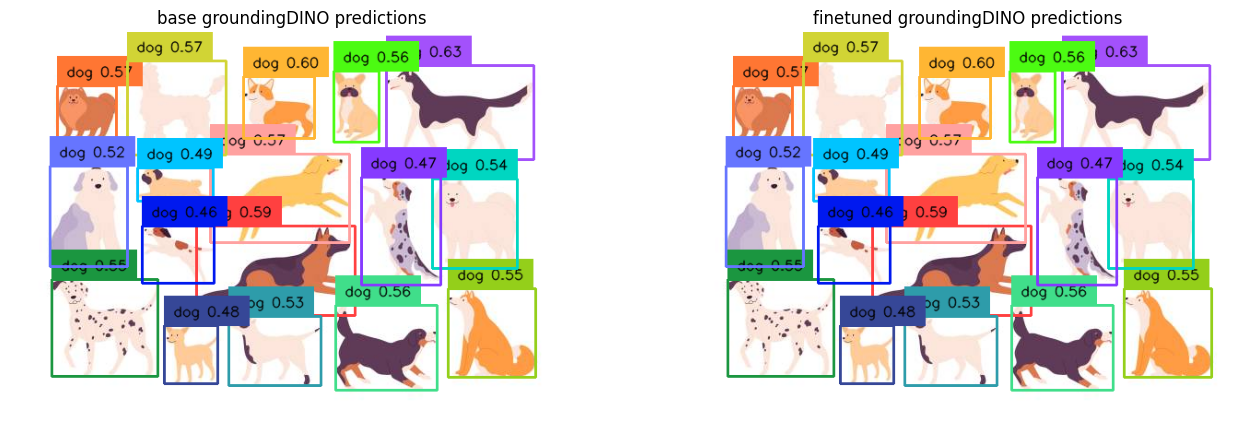

In [ ]:
# Compare basemodel and finetuned model on sample image
compare_models(unfinetuned_model,finetuned_model, image_source, image_transformed, prompt, model_names=['base groundingDINO','finetuned groundingDINO'])